# Idea: mixtures are hypercubes in copula space. So use decision tree as classifier copula.

In [1]:
import sklearn as sk
from sklearn import tree
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
import scipy.stats as scs

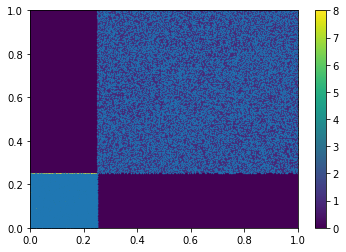

In [2]:
# Get copula data
bootstrap = False

data_p = np.concatenate([np.random.random((25000,2))/4,0.25+np.random.random((25000,2))*0.75])
if bootstrap:
    N_q = 5000
    data_q = np.random.random((N_q,2))
    data_p_upsampled = sk.utils.resample(data_p, replace=True, n_samples=N_q, random_state=42)
else:
    N_q = len(data_p)
    data_q = np.random.random((N_q,2))
    data_p_upsampled = data_p

X = np.concatenate([data_p_upsampled,data_q])
Y = np.concatenate([np.ones(N_q),np.zeros(N_q)])

plt.scatter(data_p[:,0],data_p[:,1],s=0.1)
plt.hist2d(data_p[:,0],data_p[:,1],bins=4,density=True,zorder=-10)

plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()



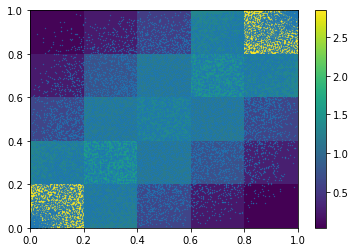

In [3]:
data_p = scs.multivariate_normal.rvs(mean=[0.,0.],cov=[[1,0.7],[0.7,1]],size=(25000))
data_p_cop = scs.norm.cdf(data_p)
data_q = scs.norm.rvs(size=(25000,2))
data_q_cop = scs.norm.cdf(data_q)
X = np.concatenate([data_p_cop,data_q_cop])
Y = np.concatenate([np.ones(data_p_cop.shape[0]),np.zeros(data_p_cop.shape[0])])
plt.scatter(data_p_cop[:,0],data_p_cop[:,1],s=0.1)
plt.hist2d(data_p_cop[:,0],data_p_cop[:,1],bins=5,density=True,zorder=-10)

plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

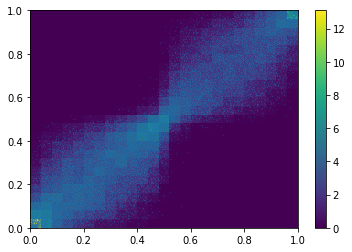

In [4]:
data_p_1 = scs.multivariate_normal.rvs(mean=[2.,2.],cov=[[1,0.7],[0.7,1]],size=(10000))
data_p_2 = scs.multivariate_normal.rvs(mean=[-2.,-2.],cov=[[1,0.7],[0.7,1]],size=(15000))
data_p = np.concatenate([data_p_1,data_p_2])
data_p_cop_1 = 0.5*(scs.norm(loc=2).cdf(data_p_1)+scs.norm(-2).cdf(data_p_1))
data_p_cop_2 = 0.5*(scs.norm(loc=2).cdf(data_p_2)+scs.norm(-2).cdf(data_p_2))
data_p_cop = np.concatenate([data_p_cop_1,data_p_cop_2])
data_q = scs.norm.rvs(size=(25000,2))
data_q_cop = scs.norm.cdf(data_q)
X = np.concatenate([data_p_cop,data_q_cop])
Y = np.concatenate([np.ones(data_p_cop.shape[0]),np.zeros(data_q_cop.shape[0])])
plt.scatter(data_p_cop[:,0],data_p_cop[:,1],s=0.01)
plt.hist2d(data_p_cop[:,0],data_p_cop[:,1],bins=25,density=True,zorder=-10)

plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

In [153]:
# Fit classifier
max_tree_depth = 30
chp = tree.DecisionTreeClassifier(criterion='entropy',max_depth=max_tree_depth)
chp = chp.fit(X, Y)

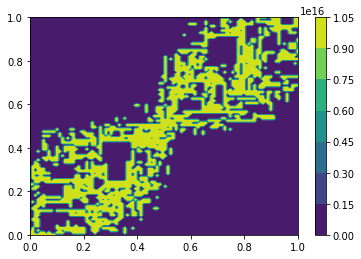

In [154]:
# compute r(x)/(1-r(x)) = cop(x)
def cop(x):
    return chp.predict_proba(np.array([x]))[0,1]/np.clip(1-chp.predict_proba(np.array([x]))[0,1],1e-16,1-(1e-16))

# plot it on meshgrid
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X_, Y_ = np.meshgrid(x_,y_)
Z = np.zeros_like(X_)
for i in range(100):
    for j in range(100):
        Z[i,j] = cop(np.array([X_[i,j],Y_[i,j]]))

plt.contourf(X_,Y_,Z)
plt.colorbar()
plt.show()

### Reverse class for stability

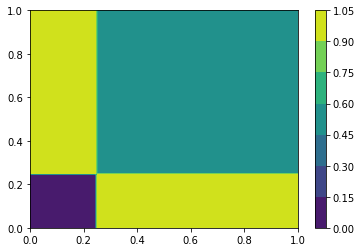

In [85]:
# fit classifier , after inverting labels
Y_rev = np.array([Y == 0][0])
chp = tree.DecisionTreeClassifier(criterion='entropy',max_depth=max_tree_depth)
chp = chp.fit(X, Y_rev)

# compute r(x)/(1-r(x)) = cop(x)
def cop(x):
    return chp.predict_proba(np.array([x]))[0,1]/np.clip(1-chp.predict_proba(np.array([x]))[0,1],1e-5,1-(1e-5))

# plot it on meshgrid
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X_, Y_ = np.meshgrid(x_,y_)
Z = np.zeros_like(X_)
for i in range(100):
    for j in range(100):
        Z[i,j] = chp.predict_proba(np.array([[X_[i,j],Y_[i,j]]]))[0,1]#cop(np.array([X_[i,j],Y_[i,j]]))

plt.contourf(X_,Y_,Z)
plt.colorbar()
plt.show()

### Random Forest for copula

### Histogram based forest???

100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


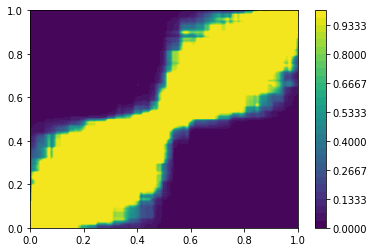

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
cl_hist = HistGradientBoostingClassifier(max_depth=30).fit(X, Y)


# Define the cop function
def cop(x):
    prob = cl_hist.predict_proba(np.array([x]))[0, 1]
    return prob / np.clip(1 - prob, 1e-16, 1 - 1e-16)

# Create meshgrid
x_ = np.linspace(0, 1, 100)
y_ = np.linspace(0, 1, 100)
X_, Y_ = np.meshgrid(x_, y_)
Z = np.zeros_like(X_)

# Compute Z values
for i in tqdm(range(100)):
    for j in range(100):
        Z[i, j] = cop(np.array([X_[i, j], Y_[i, j]])).clip(0, 1)

# Plot the results
plt.contourf(X_, Y_, Z,levels=np.linspace(0, 1, 31))
plt.colorbar()
plt.show()

### AdaBoosting

100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


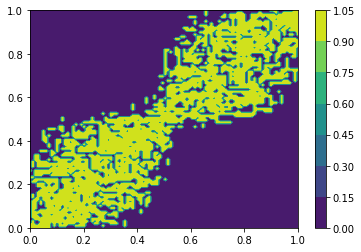

In [156]:
# fit classifier with AdaBoost
single_tree = tree.DecisionTreeClassifier(max_depth=None)
cht = AdaBoostClassifier(base_estimator=single_tree,n_estimators=16, learning_rate=1.0, algorithm='SAMME.R', random_state=990109)
cht.fit(X, Y)

# compute r(x)/(1-r(x)) = cop(x)
def cop(x):
    cop = cht.predict_proba(np.array([x]))[0,1]/np.clip(1-cht.predict_proba(np.array([x]))[0,1],1e-6,1-(1e-6))
    return cop.clip(0,1)

# plot it on meshgrid
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X_, Y_ = np.meshgrid(x_,y_)
Z = np.zeros_like(X_)
for i in tqdm(range(100)):
    for j in range(100):
        Z[i,j] = cop(np.array([X_[i,j],Y_[i,j]]))

plt.contourf(X_,Y_,Z)
plt.colorbar()
plt.show() 